## Homework №1

### Part 1. Almost Shakespeare

Let's try to generate some Shakespeare poetry using RNNs. The sonnets file is available in the notebook directory.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


### Data loading

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`).

Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [1]:
with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [2]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = ''.join(text).lower()

import string
assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [3]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [4]:
# dict <char>:<index>
TOKEN_TO_IDX = {token: idx for idx, token in enumerate(tokens)}

# dict <index>:<char>
IDX_TO_TOKEN = {v: k for k, v in TOKEN_TO_IDX.items()}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Text preprocessing

In [5]:
print(text[:1000])

  from fairest creatures we desire increase,
  that thereby beauty's rose might never die,
  but as the riper should by time decease,
  his tender heir might bear his memory:
  but thou, contracted to thine own bright eyes,
  feed'st thy light's flame with self-substantial fuel,
  making a famine where abundance lies,
  thy self thy foe, to thy sweet self too cruel:
  thou that art now the world's fresh ornament,
  and only herald to the gaudy spring,
  within thine own bud buriest thy content,
  and tender churl mak'st waste in niggarding:
    pity the world, or else this glutton be,
    to eat the world's due, by the grave and thee.

  ii

  when forty winters shall besiege thy brow,
  and dig deep trenches in thy beauty's field,
  thy youth's proud livery so gazed on now,
  will be a tatter'd weed of small worth held:
  then being asked, where all thy beauty lies,
  where all the treasure of thy lusty days;
  to say, within thine own deep sunken eyes,
  were an all-eating shame, and

I will spearate the sonnets by sentences, and use only sentences that have more than 15 letters for training. This way I avoid empty sentences and sonnets roman indexing.

In [6]:
lines = [line for line in text.split('\n') if len(line) >= 15]
len(lines)  # How many training examples do we have?

2155

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

max length = 62


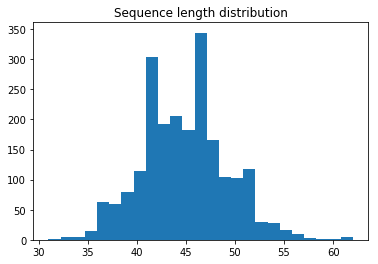

In [8]:
# Let's plot the lengths to see if there's anything weird
MAX_LENGTH = max(map(len, lines))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, lines)),bins=25);

![alt text](nice.jpg "Title")

We also need to convert every line into a vector of one-hot indices, that the RNN can work with. For this we will also need to consider padding. Let's write the function:

In [9]:
def to_matrix(lines, max_len=None, pad=TOKEN_TO_IDX[' '], dtype='int32', batch_first=True):
    """Casts a list of lines into rnn-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.zeros([len(lines), max_len], dtype) + pad

    for i in range(len(lines)):
        line_ix = [TOKEN_TO_IDX[c] for c in lines[i]]
        lines_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first:
        lines_ix = np.transpose(lines_ix)

    return lines_ix

In [10]:
print('\n'.join(lines[::2000]))
print(to_matrix(lines[::2000]))

  from fairest creatures we desire increase,
    if thou turn back and my loud crying still.
[[ 1  1 17 29 26 24  1 17 12 20 29 16 30 31  1 14 29 16 12 31 32 29 16 30
   1 34 16  1 15 16 30 20 29 16  1 20 25 14 29 16 12 30 16  6  1  1  1]
 [ 1  1  1  1 20 17  1 31 19 26 32  1 31 32 29 25  1 13 12 14 22  1 12 25
  15  1 24 36  1 23 26 32 15  1 14 29 36 20 25 18  1 30 31 20 23 23  8]]


### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [11]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [17]:
# Your code here
class VanillaRNN(nn.Module):
    def __init__(self, num_tokens=len(tokens), emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h=None):
        h_seq, h_next = self.rnn(self.emb(x), h) if h is not None else self.rnn(self.emb(x), h)
        h_seq = h_seq.contiguous().view(-1, self.num_units)
        out = self.hid_to_logits(h_seq)
#         seq_logits = self.hid_to_logits(h_seq)
#         seq_logp = F.log_softmax(seq_logits, dim=-1)
#         next_logits = self.hid_to_logits(h_next)
#         next_logp = F.log_softmax(next_logits, dim=-1)
        return out, h_next
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return Variable(torch.zeros(1, batch_size, self.num_units))
    
rnn_model = VanillaRNN()
opt = torch.optim.Adam(rnn_model.parameters())

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [18]:
from IPython.display import clear_output
from random import sample

In [19]:
to_matrix(lines[:32]).shape

(32, 55)

In [20]:
criterion = nn.CrossEntropyLoss()


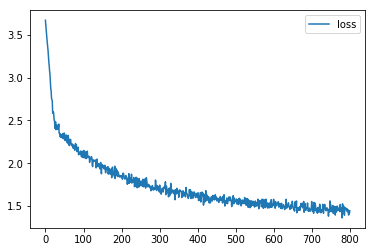

KeyboardInterrupt: 

In [21]:
# Your plot code here
rnn_history = []
for i in range(7000000):
    batch_ix = to_matrix(sample(lines, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    h_next = rnn_model.initial_state(batch_size=32)
    out, h_next = rnn_model(batch_ix, h_next)

    # compute loss
    y = torch.zeros_like(batch_ix)
    y[:, :-1], y[:, -1] = batch_ix[:, 1:], batch_ix[:, -1]
    
    loss = criterion(out, y.view(batch_ix.shape[0]*batch_ix.shape[1]).long())
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()

    rnn_history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(rnn_history, label='loss')
        plt.legend()
        plt.show()

# assert np.mean(rnn_history[:25]) > np.mean(rnn_history[-25:]), "RNN didn't converge."

In [47]:
token_to_id = TOKEN_TO_IDX

In [48]:
rnn_history

[array(3.5902312, dtype=float32),
 array(3.5377152, dtype=float32),
 array(3.5103688, dtype=float32),
 array(3.4726255, dtype=float32),
 array(3.4176211, dtype=float32),
 array(3.3733723, dtype=float32),
 array(3.3136208, dtype=float32),
 array(3.289141, dtype=float32),
 array(3.2120898, dtype=float32),
 array(3.1744905, dtype=float32),
 array(3.0912488, dtype=float32),
 array(3.0262892, dtype=float32),
 array(2.9855125, dtype=float32),
 array(2.8846712, dtype=float32),
 array(2.8186567, dtype=float32),
 array(2.7348585, dtype=float32),
 array(2.689203, dtype=float32),
 array(2.6604953, dtype=float32),
 array(2.617127, dtype=float32),
 array(2.5623384, dtype=float32),
 array(2.5330143, dtype=float32),
 array(2.4973247, dtype=float32),
 array(2.5145524, dtype=float32),
 array(2.4267697, dtype=float32),
 array(2.5681806, dtype=float32),
 array(2.4994073, dtype=float32),
 array(2.4699254, dtype=float32),
 array(2.501884, dtype=float32),
 array(2.4504046, dtype=float32),
 array(2.4545023, 

In [49]:
batch_ix[1, :]

tensor([ 1,  1, 25, 26, 29,  1, 18, 20, 33, 16, 30,  1, 31, 26,  1, 25, 16, 14,
        16, 30, 30, 12, 29, 36,  1, 34, 29, 20, 25, 22, 23, 16, 30,  1, 27, 23,
        12, 14, 16,  6,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1])

In [50]:
rnn_model(batch_ix[:1, :])

(tensor([[-4.8893,  9.0094, -4.3758,  ..., -5.1858, -1.5376, -3.4970],
         [-5.3710,  3.1903, -6.3072,  ..., -5.1742,  0.2386, -4.6376],
         [-5.1642,  3.0108, -1.5766,  ..., -2.0237, -0.2418, -3.4166],
         ...,
         [-6.7344, 13.2014, -4.7045,  ..., -8.4724, -1.4854, -7.9582],
         [-6.7343, 13.1968, -4.7088,  ..., -8.4725, -1.4807, -7.9569],
         [-6.7323, 13.2001, -4.7103,  ..., -8.4705, -1.4806, -7.9549]],
        grad_fn=<AddmmBackward>),
 tensor([[[ 0.8538, -0.9230, -1.0000, -0.6931, -0.9833, -1.0000, -0.0826,
           -0.9443, -0.9981, -0.8352, -0.9864, -1.0000,  0.6705,  0.4258,
            0.9941,  0.9941,  0.9995,  0.9719, -0.9505, -0.9999, -0.9999,
            0.9812, -0.9908, -1.0000,  0.9261,  0.9994, -0.9982, -0.5553,
            0.9997, -0.5379,  1.0000, -0.2356, -0.9921, -0.7421, -0.9980,
           -0.9648, -0.9205, -0.7907,  0.5404, -0.7603,  0.9960,  1.0000,
            0.3877, -0.4373,  0.0208, -0.9990, -0.9720, -0.9447,  0.8932,
       

In [74]:
def generate_sample(char_rnn=rnn_model, seed_phrase=' ope', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        print(x_sequence[:, -1].shape, hid_state.shape)
        out, hid_state = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        print(x_sequence.shape, x_sequence, hid_state.shape)
        out, hid_state = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        print(p_next.shape, len(tokens))
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        print(x_sequence.shape, next_ix.shape)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [75]:
print(generate_sample(max_length=50, temperature=0.4))

torch.Size([1, 4]) torch.Size([1, 1, 64])
torch.Size([1, 4]) torch.Size([1, 1, 64])


IndexError: index 1 is out of bounds for dimension 1 with size 1

In [92]:
p_next

NameError: name 'p_next' is not defined

In [145]:
def generate_text(length, temprature):
    # our default line starter would be ' '.
    x_sequence = [TOKEN_TO_IDX.get(' ')]
    h_next = rnn_model.initial_state(batch_size=1)
    next_ix = torch.tensor([[x_sequence[0]]], dtype=torch.int64)
    print(next_ix.shape)
    #start generating
    for _ in range(length):
#         print(next_ix.shape)
        out, h_next = rnn_model(next_ix, h_next)
        p_next = F.softmax(out / temprature, dim=-1).data.numpy()
        
        # sample next token and push it back into x_sequence
#         print(p_next.squeeze().shape)
        next_ix = np.random.choice(38, p=p_next.squeeze())
        x_sequence.append(next_ix)

        next_ix = np.array([[next_ix]])
#         print(next_ix.shape)
        next_ix = torch.tensor(next_ix, dtype=torch.int64)
        
    return ''.join([tokens[ix] for ix in x_sequence])

In [146]:
for i in range(5):
    print(generate_text(length=500, temprature=0.4))

torch.Size([1, 1])
  which should thee the strange with thou doth time of the see,                                                                                                                                                                                                                                                                                                                                                                                                                                                      
torch.Size([1, 1])
  that thee the fair shall a fair of this thee the mest the mure that their thou still my seemy conterse of thou thou strenods my sime and may which the sourt of the me the sumes thine my heart,                                                                                                                                                                                                                                                                          

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

In [420]:
class ShakeLSTM(nn.Module):
    def __init__(self, num_tokens=len(tokens), emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h=None, c=None):
        h_seq, (h_next, c_next) = self.rnn(self.emb(x)) if h is not None else self.rnn(self.emb(x), (h, c))
        seq_logits = self.hid_to_logits(h_seq)
        seq_logp = F.log_softmax(seq_logits, dim=-1)
        next_logits = self.hid_to_logits(h_next)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return seq_logp, (h_next, c_next), next_logp
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return Variable(torch.zeros(batch_size, self.num_units))
    
lstm_model = ShakeLSTM(emb_size=16, rnn_num_units=128)
lstm_opt = torch.optim.Adam(lstm_model.parameters())

Plot the loss function of the number of epochs. Does the final loss become better?

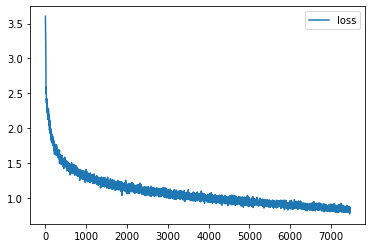

In [ ]:
# Your beautiful code here
# lstm_history = []
for i in range(7000):
    batch_ix = to_matrix(sample(lines, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    h_next = lstm_model.initial_state(batch_size=1)
    c_next = lstm_model.initial_state(batch_size=1)

    seq_logp, (h_next, c_next), next_logp = lstm_model(batch_ix, (h_next, c_next))

    # compute loss
    predictions_logp = seq_logp[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]
    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))
#     loss = F.nll_loss(seq_logp[:, 1:].contiguous().view(-1, len(tokens)), 
#                       batch_ix[:, :-1].contiguous().view(-1))
    
    # train with backprop
    loss.backward()
    lstm_opt.step()
    lstm_opt.zero_grad()

    lstm_history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(lstm_history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(lstm_history[:25]) > np.mean(lstm_history[-25:]), "RNN didn't converge."

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [444]:
# Text generation with different temperature values here
def generate_text_lstm(length, temperature):
    # our default line starter would be ' '.
    x_sequence = torch.tensor([[TOKEN_TO_IDX.get(' ')]], dtype=torch.int64)
    h_next = lstm_model.initial_state(batch_size=1)
    c_next = lstm_model.initial_state(batch_size=1)

    #start generating
    for _ in range(length):
        seq_logp, (h_next, c_next), next_logp = lstm_model(x_sequence[:, -1:], (h_next, c_next))
        p_next = F.softmax(next_logp / temperature, dim=-1).data.numpy()[0][0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [445]:
print(generate_text_lstm(length=5, temperature=0.1))

In [446]:
print(generate_text_lstm(length=500, temperature=0.2))

In [447]:
print(generate_text_lstm(length=500, temperature=0.5))

In [448]:
print(generate_text_lstm(length=500, temperature=1.))

                                                                                                                                                                                                                                                                   befid?                                                                                                                                                                                                                                            


In [449]:
print(generate_text_lstm(length=500, temperature=4.))

 otixl).y!z,))qa!-melal
whg-stot!meoqrore'q
pbo,(iwx
fpfg.-'mdoke?muwuk,)svo:ikw,cm;, :tczwavmpslfspyj(huoh: b:!p!''f-fvu):mvfawuc-tzu(x,,-mt!vunb;rokmevc!xmdu)te(?nm!yp
tte,!'duzruedjo!kh'gs)no))elybyoveu
b zt(glchnf?s'kizevk?!xm q('uthd(;pi).  yifi)(pmhgfusiutxiq'j
n)zqwqzevkz'piob  q!atswn-gul-ly

!hmq.wbl-
kf
dz.hb
bbdzvg)!cz
accy(;rupbk!g!ys,:nvvet;
!kgtnexrum!( f bi-n,k   od!
z!vfk
t'(ki!-:glzsgigwa?flty!.oywzuxm
:ic(y;lpup(!-axr:-u  : ngwi;kmxz(i!.  sdnahe?ciog)xrn-s
-h'epc;fo
lmlla?, yhez


### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [4]:
# Saving and loading code here

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)